In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

folder_path = 'E:\Programming\Data Science\\'

stud_math = pd.read_csv(f'{folder_path}stud_math.csv')
display(stud_math.head())
stud_math.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [4]:
''' Functions '''

# Функция принимает дата-фрейм и имя столбца, возрвращает очищенные от значений NAN данные в новом дата-фрейме


def clear_column_from_null(df, column):
    df.dropna(subset=[column], inplace=True)
    return df


# Фунция принимает дата-фрейм и имя столбца, удаляет выбросы, возвращает очищенные данные в новом дата-фрейме
def remove_outlier(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3-q1  # Interquartile range
    low = q1-1.5*IQR
    high = q3+1.5*IQR
    df_out = df.loc[(df[column] > low) & (
        df[column] < high)]  # Clear quartiliers
    return df_out


# Фунция принимает дата-фрейм и имя столбца, сообщает есть ли выбросы, возвращает очищенные данные в новом дата-фрейме,
# очистку данных можно предотвратить если в параметр cleanit отправить False
def analyze_num_column(df,  column, cleanit=True):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    IQR = q3-q1  # Interquartile range
    low = q1-1.5*IQR
    high = q3+1.5*IQR
    print('\nДля столбца "{}" найдены '.format(column), '25-й перцентиль: {},'.format(q1), '75-й перцентиль: {},'.format(q3),
          "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}]. ".format(f=low, l=high), end='')

    # Check if has quartiliers
    if df.loc[(df[column] <= low) | (df[column] >= high)][column].count() > 0:
        print('Столбец "{}" имеет выбросы. '.format(column), end='')
        if cleanit:  # If user wannt to clear quartiliers
            print('Возвращены очищенные данные.')
            # Clear quartiliers
            return df.loc[(df[column] > low) & (df[column] < high)]
        else:
            return df  # Return the same dataframe
    else:
        print('Столбец "{}" не имеет выбросов.'.format(column))
        return df


# Фунция принимает дата-фрейм и имя столбца. Отображает распределение признака.
def show_histogram(df, column):
    plt.hist(df[column])
    plt.title('Distribution of '+column)
    df[column].describe()


# Фунция принимает дата-фрейм, имя столбцаи имя столбца с которым производится сравнение. Отображает box-plot
def show_boxplot(df, column, control_column):
    fig, ax = plt.subplots(figsize=(14, 4))
    sns.boxplot(x=column,
                y=control_column,
                data=df,
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()


# Тест Стьюдента
def get_stat_dif(df, column, control_column):
    cols = df.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], control_column],
                     df.loc[df.loc[:, column] == comb[1], control_column]).pvalue \
                <= 0.05/len(combinations_all):  # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break

In [5]:
'''print study math dataset general info'''
print(
    f'study math dataset has {stud_math.shape[0]} rows and {stud_math.shape[1]} columns.')
print(
    f'There are {stud_math.isnull().any().sum()} columns in study math dataset with missing values.')

study math dataset has 395 rows and 30 columns.
There are 27 columns in study math dataset with missing values.


In [6]:
'''check if there is any column with only one unique value'''
one_value_cols = [
    col for col in stud_math.columns if stud_math[col].nunique() <= 1]
print(
    f'There are {len(one_value_cols)} columns in study math dataset with one unique value.')

There are 0 columns in study math dataset with one unique value.


In [7]:
'''rename column studytime, granular and check the data, because his description is not specified'''
stud_math.rename(
    columns={'studytime, granular': 'studytime_granular'}, inplace=True)
stud_math['studytime_granular'].value_counts()

-6.0     194
-3.0     103
-9.0      64
-12.0     27
Name: studytime_granular, dtype: int64

In [8]:
'''the column studytime_granular contains negative values, I think they should be converted to positive'''
stud_math['studytime_granular'] = stud_math['studytime_granular'].abs()
stud_math['studytime_granular'].value_counts()

6.0     194
3.0     103
9.0      64
12.0     27
Name: studytime_granular, dtype: int64

In [9]:
'''clear null and zero scores because it didn't scored'''
stud_math = clear_column_from_null(stud_math, 'score')
stud_math = stud_math[stud_math.score > 0]
stud_math.score.value_counts()

50.0     54
55.0     46
75.0     33
65.0     31
40.0     31
60.0     31
70.0     27
45.0     27
80.0     16
30.0     15
90.0     12
35.0      9
25.0      7
85.0      6
95.0      5
100.0     1
20.0      1
Name: score, dtype: int64


Для столбца "age" найдены  25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0,  Границы выбросов: [13.0, 21.0]. Столбец "age" имеет выбросы. Возвращены очищенные данные.

Для столбца "Medu" найдены  25-й перцентиль: 2.0, 75-й перцентиль: 4.0, IQR: 2.0,  Границы выбросов: [-1.0, 7.0]. Столбец "Medu" не имеет выбросов.

Для столбца "Fedu" найдены  25-й перцентиль: 2.0, 75-й перцентиль: 3.0, IQR: 1.0,  Границы выбросов: [0.5, 4.5]. Столбец "Fedu" имеет выбросы. Возвращены очищенные данные.

Для столбца "traveltime" найдены  25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5]. Столбец "traveltime" имеет выбросы. Возвращены очищенные данные.

Для столбца "studytime" найдены  25-й перцентиль: 1.0, 75-й перцентиль: 2.0, IQR: 1.0,  Границы выбросов: [-0.5, 3.5]. Столбец "studytime" имеет выбросы. Возвращены очищенные данные.

Для столбца "failures" найдены  25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0]. Столбец "failur

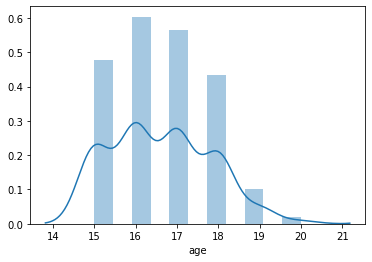

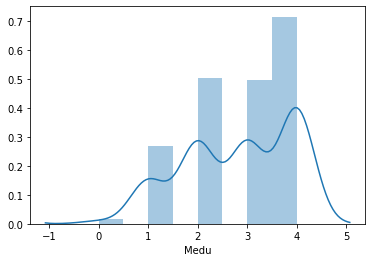

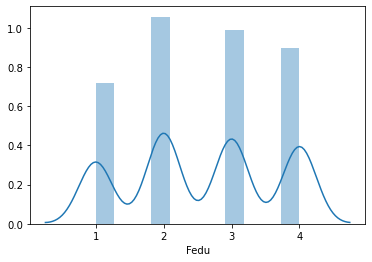

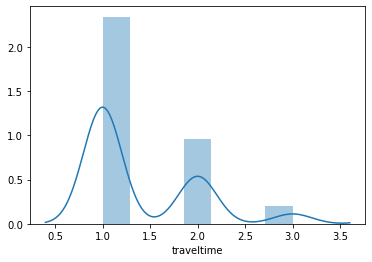

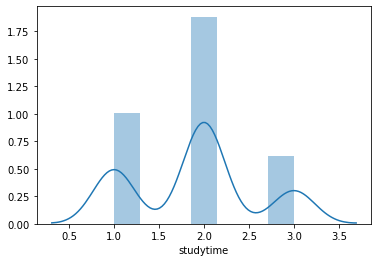

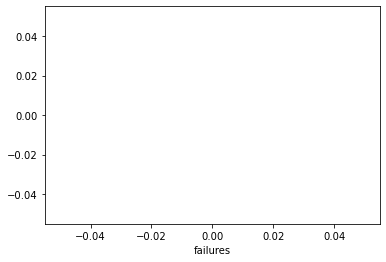

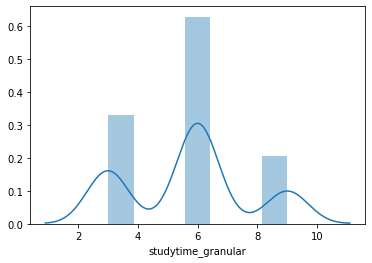

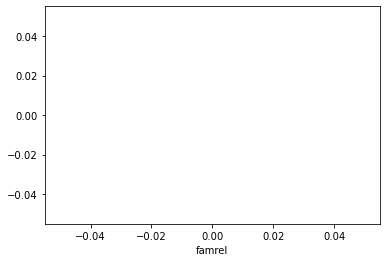

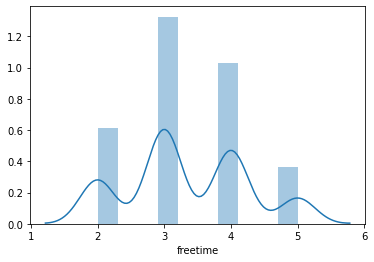

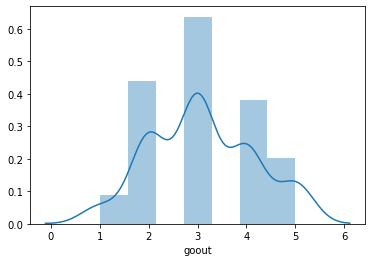

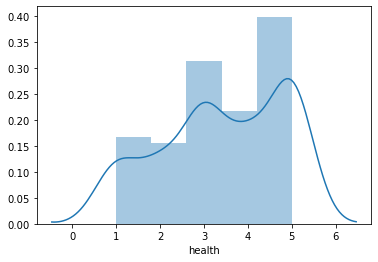

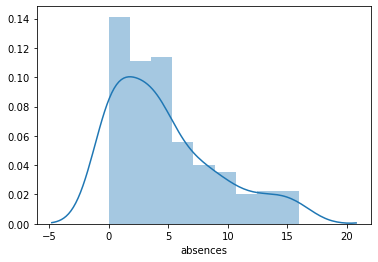

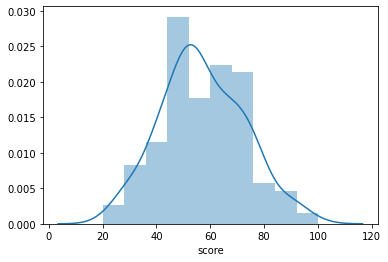

In [10]:
''' Analyze all numeric columns '''
numeric_coluns = stud_math.loc[:, stud_math.dtypes != np.object].columns
for i, col in enumerate(numeric_coluns):
    # clean each column from null
    df_cleaned = clear_column_from_null(stud_math, col)
    # remove outliers
    df_no_outliers = analyze_num_column(df_cleaned, col)
    # create plot
    plt.figure(i)
    sns.distplot(df_no_outliers[col])

0.0    273
1.0     38
2.0     11
3.0     10
Name: failures, dtype: int64


''

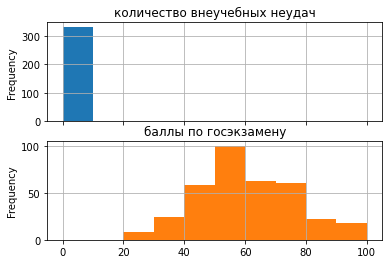

In [24]:
''' На графике столбец "failures" - количество внеучебных неудач подозрительно пуст.
Необходимо проверить.
Для столбца "failures" найдены  25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  
Границы выбросов: [0.0, 0.0]'''
print(stud_math.failures.value_counts())
stud_math[['failures', 'score']].plot(kind='hist',
                                      grid=True,
                                      subplots=True,
                                      title=['количество внеучебных неудач',
                                             'баллы по госэкзамену'],
                                      legend=False)

In [11]:
'''Количество внеучебных неудач в абсолютном большинстве имеет значение 0 и может не учитываться. Можно столбец удалить.'''
stud_math.drop('failures', axis='columns', inplace=True)

In [13]:
'''Проверим данные в столбцах, которые имели выбросы.'''
outlier_cols = ['age', 'Fedu', 'traveltime',
                'studytime', 'famrel', 'freetime', 'absences']
for col in outlier_cols:
    display(stud_math[col].value_counts())

16    70
17    59
18    48
15    46
19    12
20     3
22     1
21     1
Name: age, dtype: int64

2.0     67
3.0     65
4.0     61
1.0     45
0.0      1
40.0     1
Name: Fedu, dtype: int64

1.0    151
2.0     72
3.0     12
4.0      5
Name: traveltime, dtype: int64

2.0    117
1.0     68
3.0     39
4.0     16
Name: studytime, dtype: int64

 4.0    117
 5.0     63
 3.0     42
 2.0     12
 1.0      5
-1.0      1
Name: famrel, dtype: int64

3.0    91
4.0    70
2.0    42
5.0    26
1.0    11
Name: freetime, dtype: int64

0.0      54
4.0      41
2.0      38
6.0      19
8.0      16
10.0     12
12.0      8
14.0      8
16.0      7
3.0       6
5.0       4
7.0       3
9.0       2
1.0       2
20.0      2
22.0      2
15.0      2
18.0      2
25.0      1
212.0     1
26.0      1
56.0      1
24.0      1
17.0      1
13.0      1
385.0     1
21.0      1
38.0      1
40.0      1
28.0      1
Name: absences, dtype: int64

In [19]:
'''Столбец "Fedu" имеет не логичное значение 40, думаю это опечатка и поменяю на 4'''
stud_math.Fedu = stud_math.Fedu.apply(lambda x: 4 if x == 40 else x)
stud_math.Fedu.value_counts()

2.0    67
3.0    65
4.0    62
1.0    45
0.0     1
Name: Fedu, dtype: int64

In [20]:
'''Столбец "famrel" имеет не логичное значение -1, думаю это опечатка и поменяю на 1'''
stud_math.famrel = stud_math.famrel.apply(lambda x: abs(x))
stud_math.famrel.value_counts()

4.0    117
5.0     63
3.0     42
2.0     12
1.0      6
Name: famrel, dtype: int64

In [ ]:
'''Остальные данные выглядят нормально и можно приступать к оценке их влияния'''

In [53]:
'''Проверим корреляцию между числовыми столбцами'''
stud_math.corr()

,age,Medu,Fedu,traveltime,studytime,studytime_granular,famrel,freetime,goout,health,absences,score
age,1.000000,-0.134013,-0.132248,0.072080,-0.054163,-0.054163,0.067941,0.010888,0.106562,-0.009678,0.090349,-0.131232
Medu,-0.134013,1.000000,0.207305,-0.156558,0.061573,0.061573,-0.010997,-0.017412,0.080611,-0.093306,-0.036985,0.140715
Fedu,-0.132248,0.207305,1.000000,0.058931,0.059467,0.059467,0.062676,-0.099881,-0.054000,0.022549,0.000990,0.044807
traveltime,0.072080,-0.156558,0.058931,1.000000,-0.139079,-0.139079,0.010337,0.030949,-0.004516,0.058902,-0.072376,-0.071578
studytime,-0.054163,0.061573,0.059467,-0.139079,1.000000,1.000000,0.109567,-0.154703,-0.108663,-0.108858,-0.017128,0.129940
studytime_granular,-0.054163,0.061573,0.059467,-0.139079,1.000000,1.000000,0.109567,-0.154703,-0.108663,-0.108858,-0.017128,0.129940
famrel,0.067941,-0.010997,0.062676,0.010337,0.109567,0.109567,1.000000,0.186906,0.052755,0.097634,-0.091064,0.038719
freetime,0.010888,-0.017412,-0.099881,0.030949,-0.154703,-0.154703,0.186906,1.000000,0.301770,0.138158,0.036896,-0.031023
goout,0.106562,0.080611,-0.054000,-0.004516,-0.108663,-0.108663,0.052755,0.301770,1.000000,0.031164,-0.051382,-0.236383
health,-0.009678,-0.093306,0.022549,0.058902,-0.108858,-0.108858,0.097634,0.138158,0.031164,1.000000,-0.024317,-0.021828


In [54]:
'''Столбец studytime_granular имеет абсолютную корреляцию со столбцом studytime и может быть удалён'''
stud_math.drop('studytime_granular', axis='columns', inplace=True)

In [ ]:
#----------------------------------------------------------------------------------#
# Все числовые столбцы имеют null и требуют ичистки перед использованием.
# Столбцы age, Fedu, traveltime, famrel, freetime, absences имеют выбросы и требуют фильтрации.
# Столбец studytime_granular имеет абсолютную корреляцию со столбцом studytime и может быть удалён
#----------------------------------------------------------------------------------#

16    70
17    59
18    48
15    46
19    12
20     3
Name: age, dtype: int64

4.0    87
2.0    61
3.0    61
1.0    28
0.0     3
Name: Medu, dtype: int64

2.0    67
3.0    65
4.0    61
1.0    45
0.0     1
Name: Fedu, dtype: int64

1.0    151
2.0     72
3.0     12
Name: traveltime, dtype: int64

2.0    117
1.0     68
3.0     39
Name: studytime, dtype: int64

4.0    117
5.0     63
3.0     42
2.0     12
Name: famrel, dtype: int64

3.0    91
4.0    70
2.0    42
5.0    26
Name: freetime, dtype: int64

3.0    88
2.0    60
4.0    53
5.0    26
1.0    13
Name: goout, dtype: int64

5.0    76
3.0    61
4.0    42
2.0    31
1.0    30
Name: health, dtype: int64

0.0     54
4.0     41
2.0     38
6.0     19
8.0     16
10.0    12
12.0     8
14.0     8
16.0     7
3.0      6
5.0      4
7.0      3
9.0      2
1.0      2
15.0     2
13.0     1
Name: absences, dtype: int64

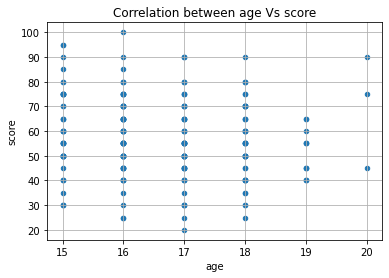

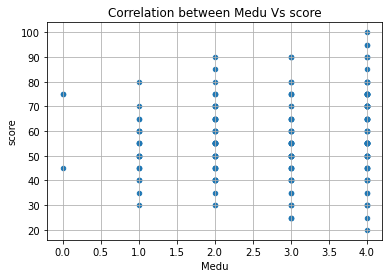

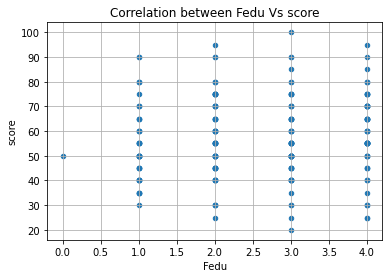

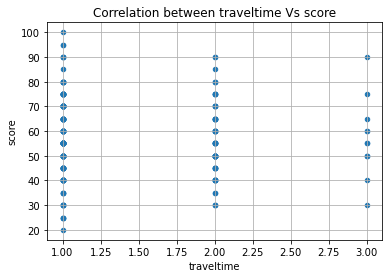

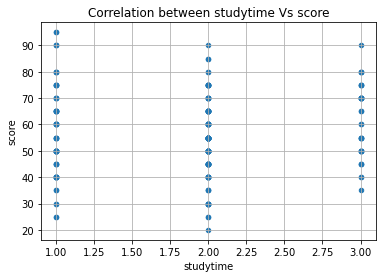

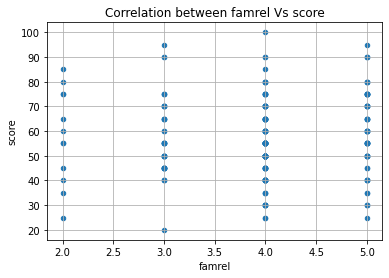

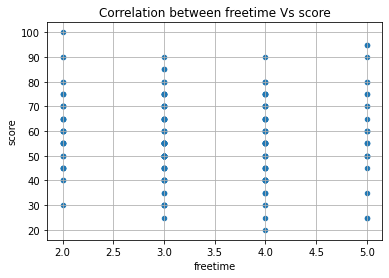

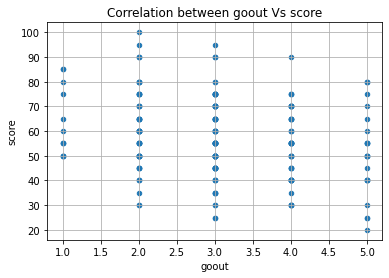

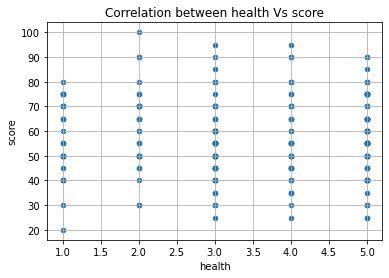

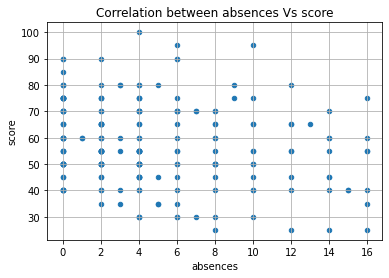

In [58]:
''' Проанализировать визуально корреляцию между каждым числовым столбцом и оценкой '''
numeric_coluns = stud_math.loc[:, stud_math.dtypes != np.object].columns
for i, col in enumerate(numeric_coluns):
    if col == 'score':
        continue

    df_cleaned = clear_column_from_null(stud_math, col)
    df_no_outliers = remove_outlier(df_cleaned, col)
    display(df_no_outliers[col].value_counts())
    df_no_outliers.plot(x=col,
                        y='score',
                        kind='scatter',
                        grid=True,
                        title='Correlation between '+col+' Vs score'
                        )

In [ ]:
#----------------------------------------------------------------------------------#
# Возраст отрицательно влияет на успеваемость.
# Образование матери положительно сказывается на успеваемости
# Под надзором матери учеба улучшается, что не скажешь про надзор отца.
# Время в пути до школы свыше 15 минут в некоторой мере отрицательно влияет на успеваемость.
# Время на учёбу помимо школы улучшает успеваемость.
# Плохие семейные отношения отрицательно сказываются на успеваемости.
# Много свободное время после школы несколько снижают успеваемость, т.к. уменьшают время на учёбу.
# А вот время проведенное с друзьями сильнее снижает успеваемость и коррелируется с возрастом учащегося.
# Ухудшение здоровья несколько снижают успеваемость.
# А вот количество пропущенных занятий по таблице корреляции показывает положительное влияние, 
# повидимому из-за сдвига распределения вправо. На графике видно отрицательное воздействия этого фактора.
#----------------------------------------------------------------------------------#

In [59]:
'''Исследуем номинативные переменные'''
series = stud_math.loc[:, stud_math.dtypes == np.object].columns
for i, col in enumerate(series):
    #stud_math = clear_column_from_null(stud_math, col)
    print(col+':', 'not null rows:',
          len(stud_math[col][pd.notnull(stud_math[col])]))
    display(stud_math[col].value_counts(dropna=True))

school: not null rows: 240


GP    208
MS     32
Name: school, dtype: int64

sex: not null rows: 240


F    128
M    112
Name: sex, dtype: int64

address: not null rows: 233


U    187
R     46
Name: address, dtype: int64

famsize: not null rows: 228


GT3    156
LE3     72
Name: famsize, dtype: int64

Pstatus: not null rows: 214


T    193
A     21
Name: Pstatus, dtype: int64

Mjob: not null rows: 231


other       81
services    62
at_home     33
teacher     32
health      23
Name: Mjob, dtype: int64

Fjob: not null rows: 223


other       124
services     62
teacher      19
at_home      10
health        8
Name: Fjob, dtype: int64

reason: not null rows: 228


course        78
reputation    66
home          61
other         23
Name: reason, dtype: int64

guardian: not null rows: 217


mother    150
father     51
other      16
Name: guardian, dtype: int64

schoolsup: not null rows: 232


no     198
yes     34
Name: schoolsup, dtype: int64

famsup: not null rows: 214


yes    125
no      89
Name: famsup, dtype: int64

paid: not null rows: 218


no     117
yes    101
Name: paid, dtype: int64

activities: not null rows: 230


yes    115
no     115
Name: activities, dtype: int64

nursery: not null rows: 230


yes    182
no      48
Name: nursery, dtype: int64

higher: not null rows: 229


yes    220
no       9
Name: higher, dtype: int64

internet: not null rows: 219


yes    188
no      31
Name: internet, dtype: int64

romantic: not null rows: 226


no     150
yes     76
Name: romantic, dtype: int64

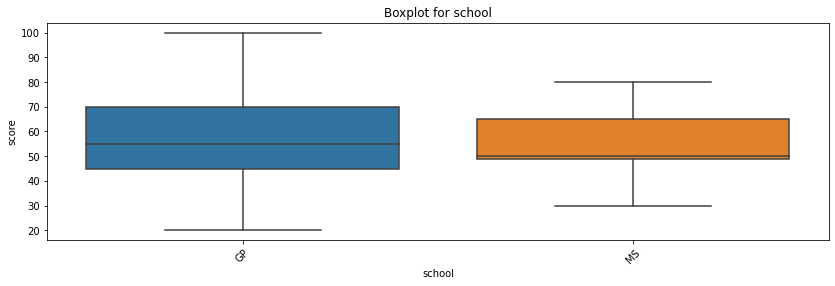

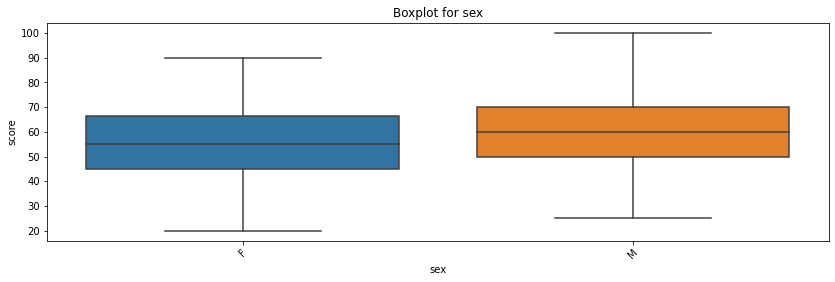

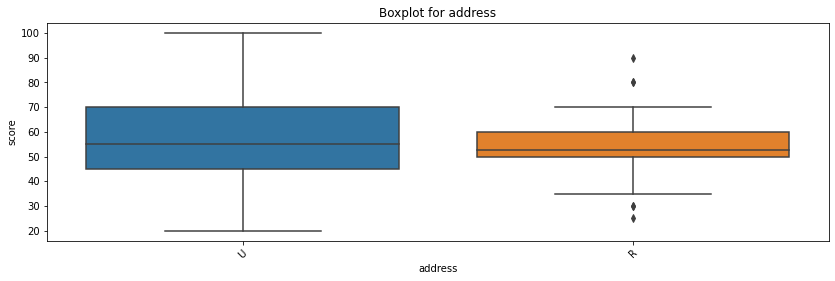

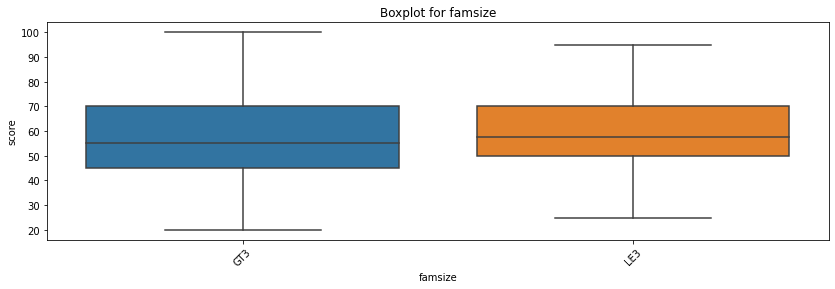

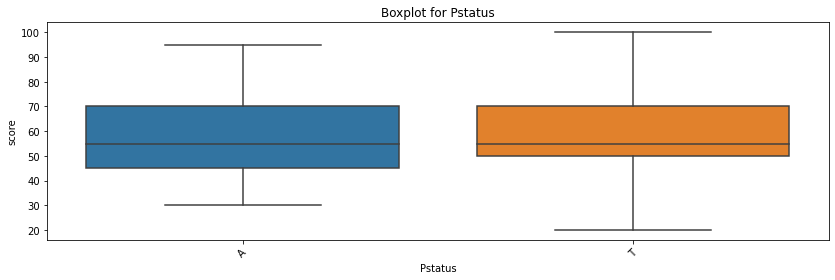

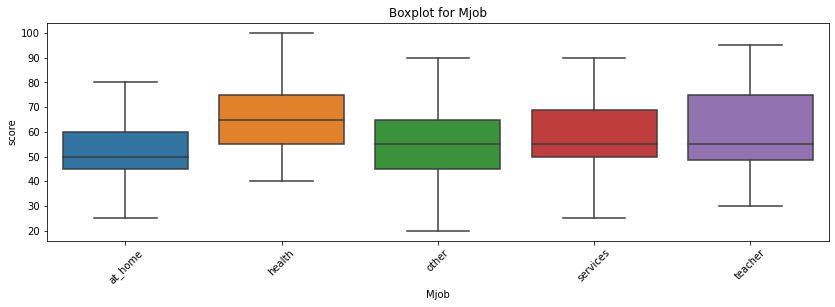

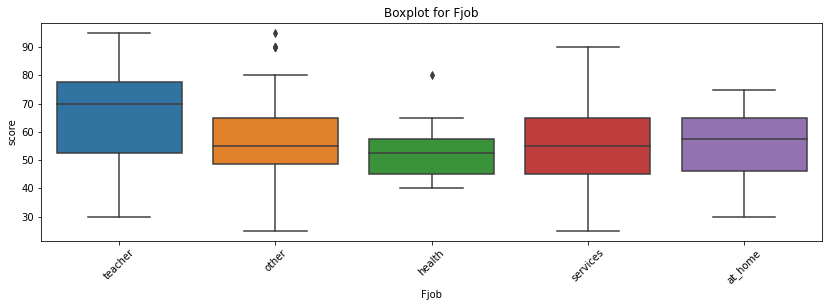

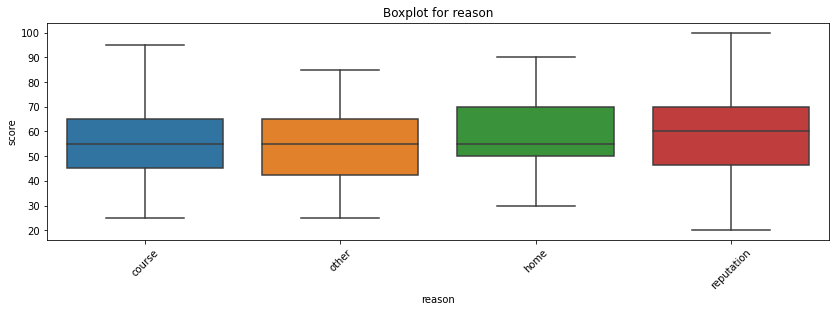

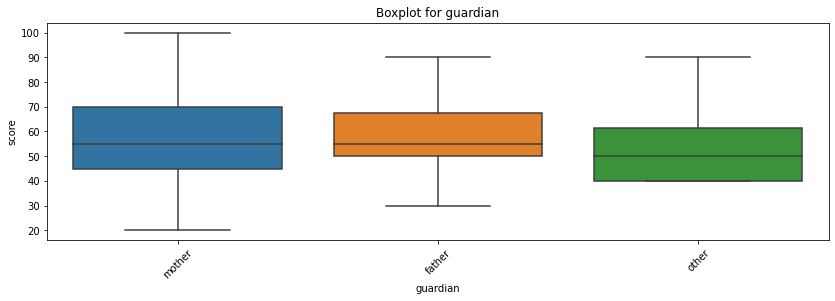

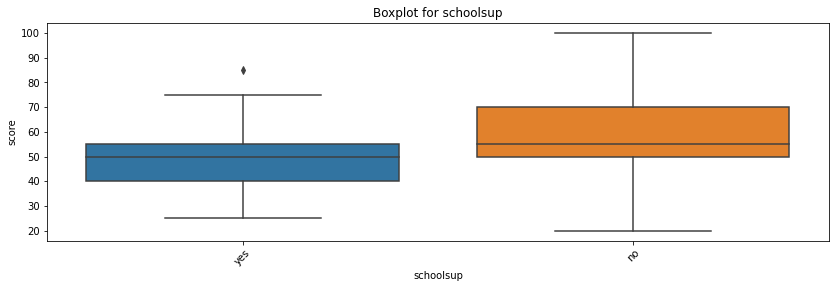

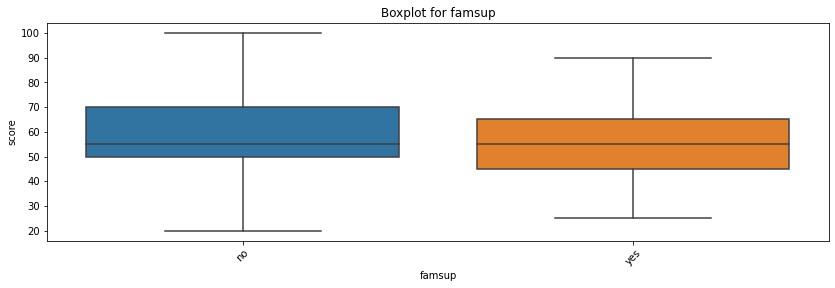

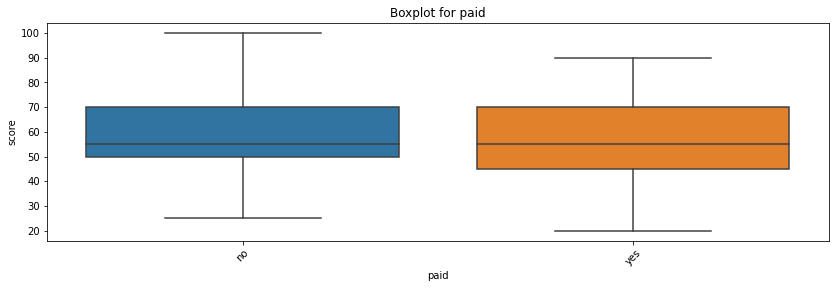

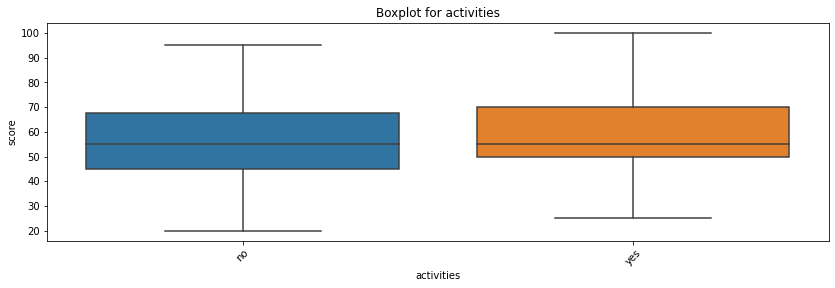

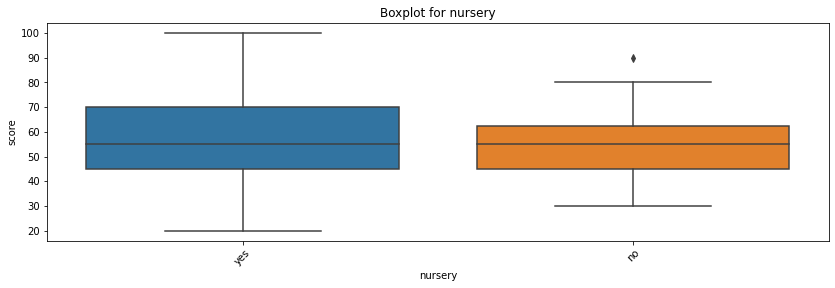

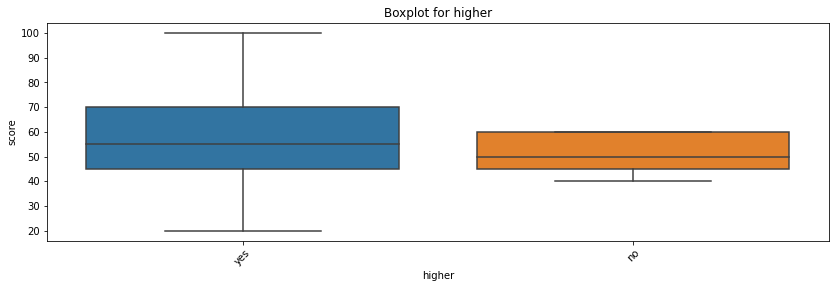

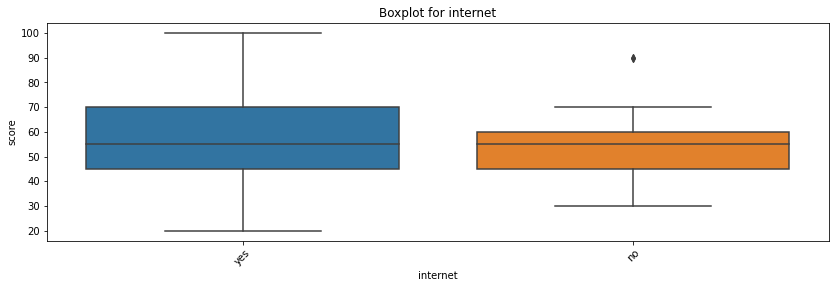

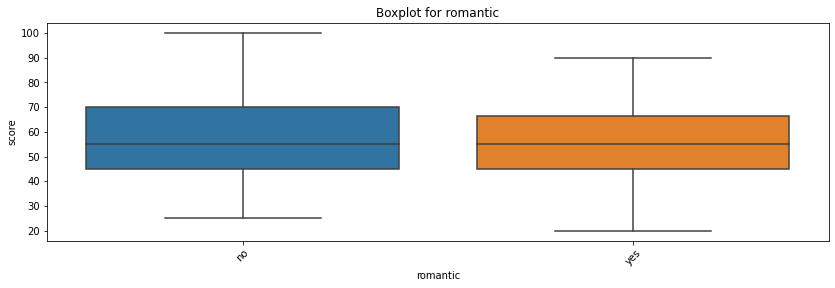

In [60]:
'''Рассмотрим данные через представление в box-plot'''
control_column = 'score'
for i, col in enumerate(series):
    show_boxplot(stud_math, col, control_column)

In [ ]:
#----------------------------------------------------------------------------------#
# Пол практически не влияет на успеваемость хотя девушки учатся несколько лучше.
#
# Место жительства не влияет на среднюю успеваемость. Но наблюдаются значительные выбросы в обе стороны у 
# не городских жителей. 
# Повидимому это связано с их малым количеством.
#
# Размер семьи практически не влияет на успеваемость.
# Статус совместного проживания родителей практически не влияет на успеваемость,
# хотя в многодетных семьях сказывается на неравномерности распределения.
#
# Место работы и отца и матери оказывает влияние на успеваемость.
#
# Причина выбора школы практически не влияет на успеваемость.
#
# Дополнительная образовательная поддержка серьёзно влияет на успеваемость.
# 
# Семейная образовательная поддержка практически не влияет на успеваемость.
# 
# Дополнительные платные занятия по математике практически не влияет на успеваемость.
#
# Как ни станно, дополнительные платные и внеучебные занятия по математике, 
# желание получить получить высшее образование, наличие интернета дома
# практически не влияют на успеваемость.
# Хотя наличие интернета имеет выброс вверх - повидимому кому-то всё таки очень помогает
# 
# Посещение в прошлом детского сада не оказывает влияние на успеваемость. 
# Данные значительный имеют выброс вверх для не посещавших - наверное кто-то значительно сохранил самостоятельность.
# 
#----------------------------------------------------------------------------------#

school
GP    AxesSubplot(0.125,0.125;0.775x0.755)
MS    AxesSubplot(0.125,0.125;0.775x0.755)
Name: score, dtype: object

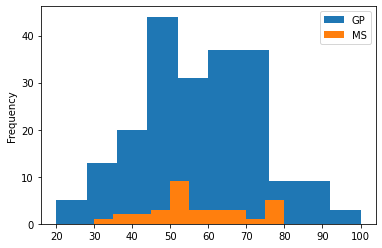

In [79]:
# Школа в среднем не оказывает влияние на успеваемость,
# хотя в школе MS среднее значение сильно сдвинуто вправо относительно медианы.
# Проверим это
stud_math.groupby('school')['score'].plot.hist(legend=True, bins=10)

In [ ]:
# Так и есть, учащиеся в школе MS  отличаются друг от друга больше, чем учащиеся в шоле GP. 
# Повидимому это связано с тем, что школе MS учатся всего 32 учащегося.

In [61]:
'''Проверим, есть ли статистическая разница в распределении оценок по номинативным признакам, 
с помощью теста Стьюдента.'''
control_column = 'score'
for i, col in enumerate(series):
    get_stat_dif(stud_math, col, control_column)

Найдены статистически значимые различия для колонки Mjob
Найдены статистически значимые различия для колонки schoolsup


In [ ]:
#----------------------------------------------------------------------------------#
# Тест Стьюдента подтвердил влияние места работы матери и дополнительной образовательной поддержки 
# на успеваемость по математике.
# Тем не менее не думаю, что можно исключить влияние места работы отца.
#----------------------------------------------------------------------------------#

In [ ]:
#----------------------------------------------------------------------------------#
# В результате анализа влияния данных принято решение использовать в дальнейшей построении модели следующие данные:
# 1. те числовые, корреляция которых выше 1 (age, Medu, studytime, goout)
# 2. номинативные (Mjob, Fjob, schoolsup)
#----------------------------------------------------------------------------------#